<a href="https://colab.research.google.com/github/fnilvuwu/age-detection/blob/main/age_detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from google.colab.patches import cv2_imshow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!tar -xf "/content/drive/MyDrive/UTKFace.tar.gz"

In [2]:
all_images = os.listdir('/content/UTKFace/')
ranges = ['1-2','3-9','10-20','21-27','28-45','46-65','66-116']

X = []
y = []

l = len(all_images)

for a in range(l):
    X.append(cv2.imread(f'/content/UTKFace/{all_images[a]}',0))
    age = int(all_images[a].split('_')[0])
    
    if age>=1 and age<=2:
        y.append(0)
    elif age>=3 and age<=9:
        y.append(1)
    elif age>=10 and age<=20:
        y.append(2)
    elif age>=21 and age<=27:
        y.append(3)
    elif age>=28 and age<=45:
        y.append(4)
    elif age>=46 and age<=65:
        y.append(5)
    elif age>=66 and age<=116:
        y.append(6)
# we are saving the X and y arrays in npz compressed format so that we don’t need to read images again and again.
np.savez_compressed('compressed image data.npz',x=X,y=y)

In [3]:
loaded = np.load('compressed image data.npz')

x = loaded['x']
y = loaded['y']

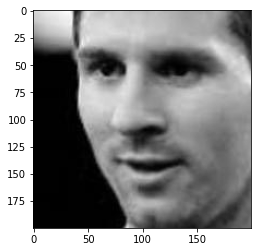

In [4]:
plt.imshow(X[0],cmap='gray')

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from keras.utils import np_utils

y = np_utils.to_categorical(y)

In [7]:
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [9]:
print(X_train[0])

[[ 66  66  65 ... 113 117 120]
 [ 65  65  64 ... 114 118 121]
 [ 64  63  63 ... 114 119 123]
 ...
 [252 247 240 ... 233 239 243]
 [249 241 231 ... 226 233 237]
 [243 234 221 ... 222 228 232]]


In [10]:
X_train = np.array(X_train).reshape(-1,200,200,1)

In [11]:
X_test = np.array(X_test).reshape(-1,200,200,1)

In [12]:
IMG_HEIGHT = 200
IMG_WIDTH = 200
IMG_SIZE = (IMG_HEIGHT,IMG_WIDTH)
batch_size = 128
epochs = 60

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   rotation_range=15)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_data = train_datagen.flow(X_train,y_train,batch_size)

test_data = test_datagen.flow(X_test,y_test,batch_size)

In [15]:
final_cnn = Sequential()
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(MaxPooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(MaxPooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(MaxPooling2D(pool_size=(2,2)))
final_cnn.add(GlobalMaxPool2D())

final_cnn.add(Flatten())

final_cnn.add(Dense(128, activation='relu'))

final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

In [16]:
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
checkpoint = ModelCheckpoint(filepath="models/final_cnn_model_checkpoint1.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [18]:
history = final_cnn.fit(train_data,
                    batch_size=512,
                    validation_data=test_data,
                    epochs=60,
                    callbacks=[checkpoint],
                    shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                    ) 

Epoch 1/60
130/130 [==============================] - ETA: 0s - loss: 1.7345 - accuracy: 0.3211
Epoch 1: val_accuracy improved from -inf to 0.28455, saving model to models/final_cnn_model_checkpoint1.h5
130/130 [==============================] - 63s 407ms/step - loss: 1.7345 - accuracy: 0.3211 - val_loss: 1.7172 - val_accuracy: 0.2845
Epoch 2/60
130/130 [==============================] - ETA: 0s - loss: 1.6733 - accuracy: 0.3302
Epoch 2: val_accuracy improved from 0.28455 to 0.37256, saving model to models/final_cnn_model_checkpoint1.h5
130/130 [==============================] - 52s 403ms/step - loss: 1.6733 - accuracy: 0.3302 - val_loss: 1.5955 - val_accuracy: 0.3726
Epoch 3/60
130/130 [==============================] - ETA: 0s - loss: 1.5787 - accuracy: 0.3607
Epoch 3: val_accuracy improved from 0.37256 to 0.38619, saving model to models/final_cnn_model_checkpoint1.h5
130/130 [==============================] - 52s 398ms/step - loss: 1.5787 - accuracy: 0.3607 - val_loss: 1.5142 - val_

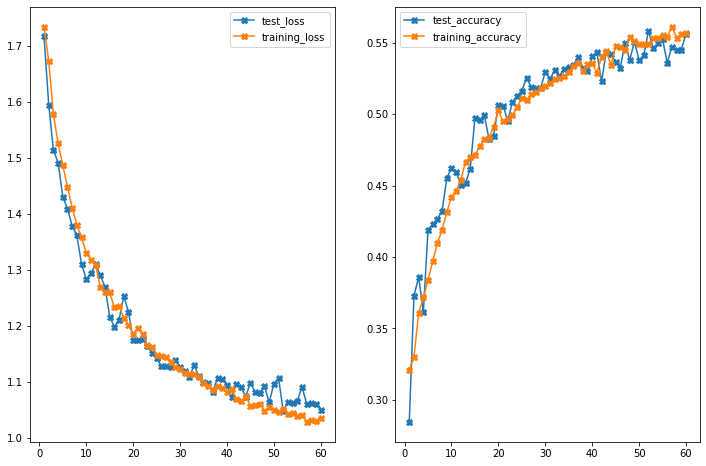

In [19]:
plotting_data_dict = history.history

plt.figure(figsize=(12,8))

test_loss = plotting_data_dict['val_loss']
training_loss = plotting_data_dict['loss']
test_accuracy = plotting_data_dict['val_accuracy']
training_accuracy = plotting_data_dict['accuracy']

epochs = range(1,len(test_loss)+1)

plt.subplot(121)
plt.plot(epochs,test_loss,marker='X',label='test_loss')
plt.plot(epochs,training_loss,marker='X',label='training_loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs,test_accuracy,marker='X',label='test_accuracy')
plt.plot(epochs,training_accuracy,marker='X',label='training_accuracy')
plt.legend()

plt.savefig('training.png')

In [24]:
def predict_age(string_path):
  face = cv2.imread(string_path)
  cv2_imshow(face)
  face = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
  face = cv2.resize(face,(200,200))
  face = face.reshape(1,200,200,1)
  age = final_cnn.predict(face)
  return ranges[np.argmax(age)]


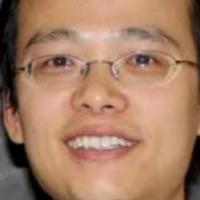

1/1 [==============================] - 0s 15ms/step


'21-27'

In [31]:
predict_age("/content/age24test.jpg")

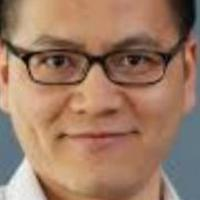

1/1 [==============================] - 0s 14ms/step


'21-27'

In [32]:
predict_age("/content/age48test.jpg")

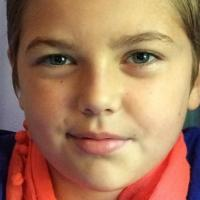

1/1 [==============================] - 0s 15ms/step


'3-9'

In [33]:
predict_age("/content/age11test.jpg")